In [1]:
import numpy as np
import heartpy as hp
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from scipy.signal import find_peaks, argrelextrema
from scipy import integrate

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the datasets
mat = scipy.io.loadmat(r"C:\Users\nitar\OneDrive - Virginia Tech\BMES 4015\Example ML Algorithms from Lit Reviews\T2TGAN - data\part_1.mat")
records = [record for record in mat['p'][0]]
PPG = np.array(records[0][0])
ABP = np.array(records[0][1])
ECG = np.array(records[0][2])
ECG_norm = preprocessing.minmax_scale(ECG,feature_range=(0, 1))
PPG_norm = preprocessing.minmax_scale(PPG,feature_range=(0, 1))
ABP_norm = preprocessing.minmax_scale(ABP,feature_range=(0, 1))

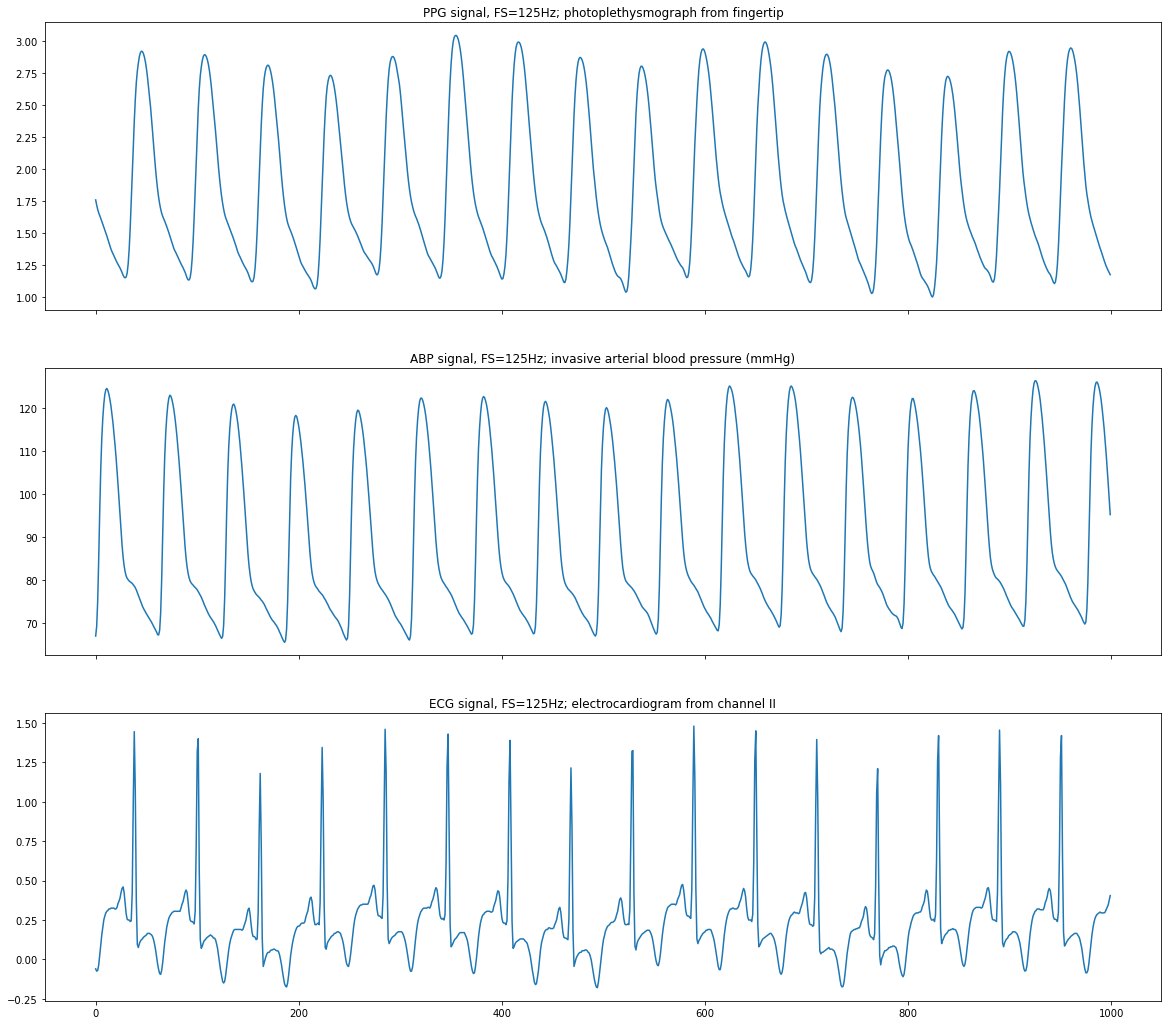

In [3]:
# Create three subplots 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,sharex=True,figsize=(20,18))
# plotting the first 8 seconds of the first record
ax1.plot(PPG[:1000])
ax1.title.set_text('PPG signal, FS=125Hz; photoplethysmograph from fingertip')
ax2.plot(ABP[:1000])
ax2.title.set_text('ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)')
ax3.plot(ECG[:1000])
ax3.title.set_text('ECG signal, FS=125Hz; electrocardiogram from channel II')

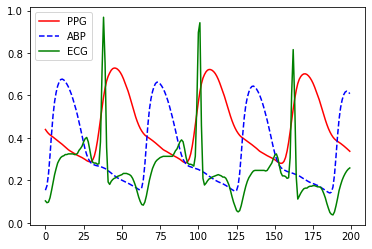

In [4]:
plt.plot(PPG_norm[:200],'r',label='PPG')
plt.plot(ABP_norm[:200],'b--',label='ABP')
plt.plot(ECG_norm[:200],'g',label='ECG')
plt.legend(loc="upper left")

## ECG Preprocessing

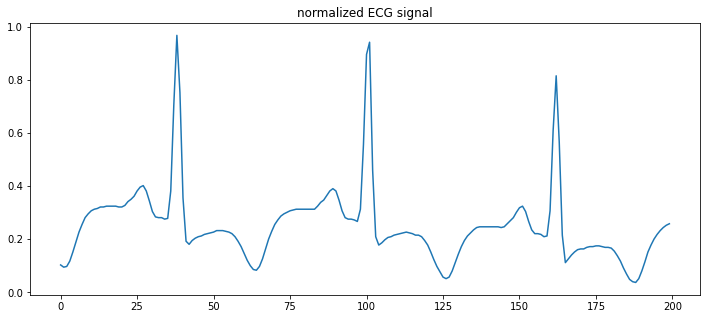

In [5]:
plt.figure(figsize=(12,5))
plt.title('normalized ECG signal')
plt.plot(ECG_norm[:200])
plt.show()

In [6]:
peak = find_peaks(ECG_norm, height=0.01, prominence=0.01)
r_peak = []
p_peak = []
t_peak = []
for i in range(len(peak[0])-2):
    if i == 0:
        p_peak.append(peak[0][i])
    else:
        if ECG_norm[peak[0][i]] > 0.7:
            r_peak.append(peak[0][i])
            if ECG_norm[peak[0][i+1]] < 0.7:
                p_peak.append(peak[0][i+2])
            if ECG_norm[peak[0][i+2]] < 0.7:
                t_peak.append(peak[0][i+1])
all_peaks = sorted([*set(r_peak + p_peak + t_peak)])

In [7]:
q_pt = []
s_pt = []
q_idx = []
s_idx = []
for i in range(len(all_peaks)-1):
    if ECG_norm[all_peaks[i]] > 0.7:
        ptp1 = ECG_norm[all_peaks[i-1]:all_peaks[i]]
        q_pt.append(min(ptp1))
        q_idx.append((np.where(ptp1 == min(ptp1))[0][0]+all_peaks[i-1]))
        ptp2 = ECG_norm[all_peaks[i]:all_peaks[i+1]]
        s_pt.append(min(ptp2))
        s_idx.append((np.where(ptp2 == min(ptp2))[0][0]+all_peaks[i]))

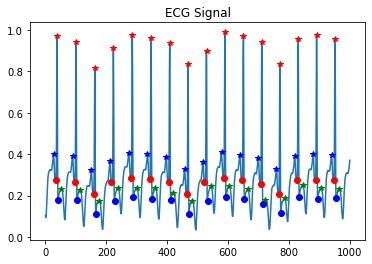

In [8]:
plt.figure()
plt.plot(ECG_norm[:1000])
plt.plot(r_peak[:16], ECG_norm[r_peak[:16]],'r*')
plt.plot(p_peak[:16], ECG_norm[p_peak[:16]],'b*')
plt.plot(t_peak[:16], ECG_norm[t_peak[:16]],'g*')
plt.plot(q_idx[:16], q_pt[:16],'ro')
plt.plot(s_idx[:16], s_pt[:16],'bo')
plt.title('ECG Signal')
plt.show()

## PPG Preprocessing

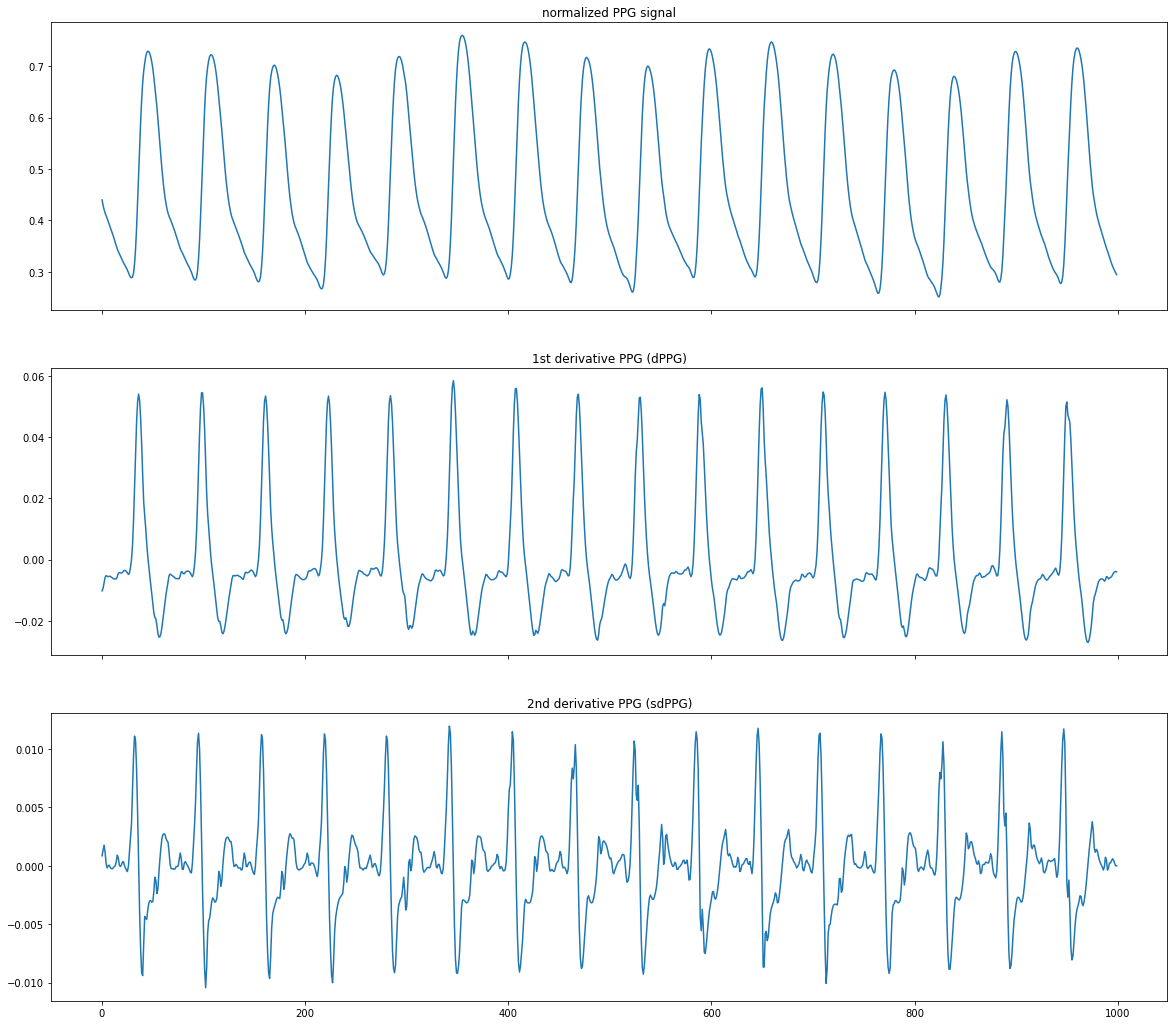

In [9]:
# 1st derivative
PPG_d = np.gradient(PPG_norm)
# 2nd derivative
PPG_sd = np.gradient(PPG_d)

# Create three subplots 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,sharex=True,figsize=(20,18))
# plotting the first 8 seconds of the first record
ax1.plot(PPG_norm[:1000])
ax1.title.set_text('normalized PPG signal')
ax2.plot(PPG_d[:1000])
ax2.title.set_text('1st derivative PPG (dPPG)')
ax3.plot(PPG_sd[:1000])
ax3.title.set_text('2nd derivative PPG (sdPPG)')

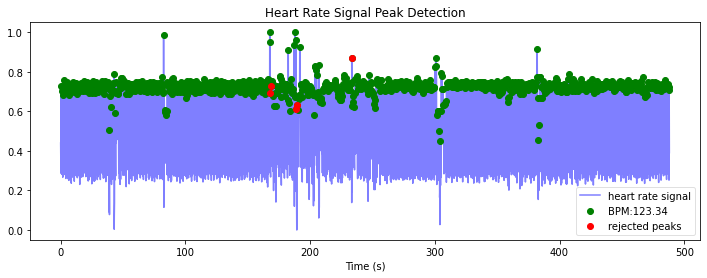

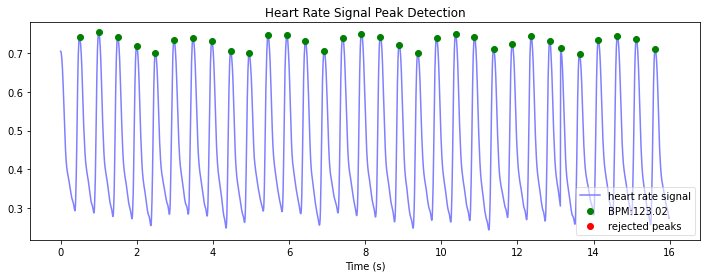

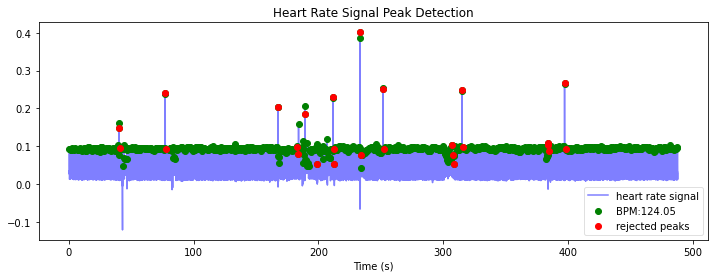

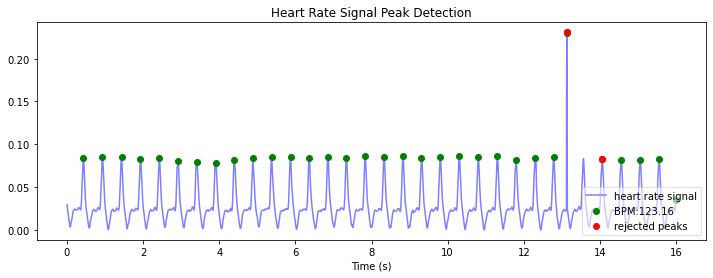

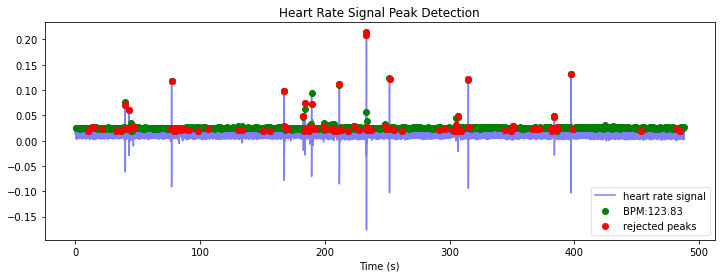

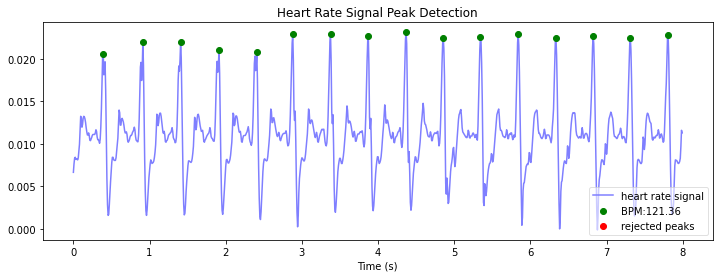

In [10]:
# running the PPG peak detection analysis 
wd1, m1 = hp.process(PPG_norm, sample_rate = 125) # full array
hp.visualizeutils.plotter(wd1, m1, figsize=(12,4))
wd2, m2 = hp.process(PPG_norm[8000:10000], sample_rate = 125) # full array
hp.visualizeutils.plotter(wd2, m2, figsize=(12,4))
wd_d1, m_d1 = hp.process(PPG_d, sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_d1, m_d1, figsize=(12,4))
wd_d2, m_d2 = hp.process(PPG_d[8000:10000], sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_d2, m_d2, figsize=(12,4))
wd_sd1, m_sd1 = hp.process(PPG_sd, sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_sd1, m_sd1, figsize=(12,4))
wd_sd2, m_sd2 = hp.process(PPG_sd[8000:9000], sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_sd2, m_sd2, figsize=(12,4))

In [11]:
# (a) systolic peaks
systolic_peak_idx = wd1['peaklist'] # array of peak indices
systolic_peak = wd1['ybeat'] # array of peak values

In [12]:
# (b1) valley points for PPG
ppg_valley_point_idx = [] # array of valley point indices
ppg_valley_point = [] # array of valley point values
for i in range(len(systolic_peak)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = systolic_peak_idx[i] # index of 1st peak
        ptp = PPG_norm[p1:p2]
        min_val = min(ptp)
        ppg_valley_point.append(min_val)
        min_idx = np.where(ptp == min_val)
        ppg_valley_point_idx.append(min_idx[0][0].tolist()) 
    else: 
        p1 = systolic_peak_idx[i-1] # index of 1st peak
        p2 = systolic_peak_idx[i] # index of 2nd peak
        ptp = PPG_norm[p1:p2]
        min_val = min(ptp)
        ppg_valley_point.append(min_val)
        min_idx = np.where(ptp == min_val) + p1
        ppg_valley_point_idx.append(min_idx[0][0].tolist())

In [13]:
# (b2) valley points and lowest points for dPPG
dppg_peak_idx = wd_d1['peaklist']
dppg_peak = wd_d1['ybeat']
dppg_valley_point_idx = [] # array of valley point indices
dppg_valley_point = [] # array of valley point values
dppg_dDA_point_idx = [] # array of lowest point indices
dppg_dDA_point = [] # array of lowest point value

# valley points
for i in range(len(dppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        mins = argrelextrema(ptp, np.less)
        dppg_valley_point_idx.append(mins[0][-1])
        dppg_valley_point.append(ptp[mins[0][-1]])
    else:
        p1 = dppg_peak_idx[i-1] # index of 1st peak
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        if len(ptp) > 20:
            mins = argrelextrema(ptp, np.less)
            if ptp[mins[0][-1]] != 0:
                dppg_valley_point_idx.append(mins[0][-1] + p1)
                dppg_valley_point.append(ptp[mins[0][-1]])
            
# lowest points
for i in range(len(dppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        min_val = min(ptp)
        dppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val)
        dppg_dDA_point_idx.append(min_idx[0][0].tolist())
    else:
        p1 = dppg_peak_idx[i-1] # index of 1st peak
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        min_val = min(ptp)
        dppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val) + p1
        dppg_dDA_point_idx.append(min_idx[0][0].tolist())

In [14]:
# (b3) valley points and lowest points for sdPPG
sdppg_peak_idx = wd_sd1['peaklist']
sdppg_peak = wd_sd1['ybeat']
sdppg_valley_point_idx = [] # array of valley point indices
sdppg_valley_point = [] # array of valley point values
sdppg_dDA_point_idx = [] # array of lowest point indices
sdppg_dDA_point = [] # array of lowest point value

# valley points
for i in range(len(sdppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        mins = argrelextrema(ptp, np.less)
        sdppg_valley_point_idx.append(mins[0][-1])
        sdppg_valley_point.append(ptp[mins[0][-1]])
    else:
        p1 = sdppg_peak_idx[i-1] # index of 1st peak
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        if len(ptp) > 20:
            mins = argrelextrema(ptp, np.less)
            if ptp[mins[0][-1]] != 0:
                sdppg_valley_point_idx.append(mins[0][-1] + p1)
                sdppg_valley_point.append(ptp[mins[0][-1]])
            
# lowest points
for i in range(len(sdppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        min_val = min(ptp)
        sdppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val)
        sdppg_dDA_point_idx.append(min_idx[0][0].tolist())
    else:
        p1 = sdppg_peak_idx[i-1] # index of 1st peak
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        min_val = min(ptp)
        sdppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val) + p1
        sdppg_dDA_point_idx.append(min_idx[0][0].tolist())

In [15]:
# (c) max/min slope values 
slopeval_ppg = [PPG_norm[i] for i in wd_d1['peaklist']]
slopeval_ppg_idx = wd_d1['peaklist']
slopeval_dppg = [PPG_d[i] for i in wd_sd1['peaklist']]
slopeval_dppg_idx = wd_sd1['peaklist']

In [16]:
# (d) dicrotic notch points
dn = scipy.signal.find_peaks(PPG_sd, distance=25)
seconday_idx = [dn[0][index] for index in range(0, len(dn[0]), 2)]
dicrotic_notch_idx = [item for item in seconday_idx if PPG_sd[item] <= 0.05]
dicrotic_notch = [PPG_norm[i] for i in dicrotic_notch_idx]

## ABP Preprocessing

Text(0.5, 1.0, 'ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)')

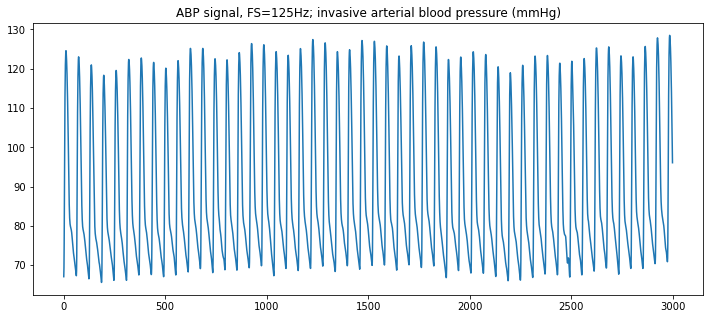

In [17]:
plt.figure(figsize=(12,5))
plt.plot(ABP[:3000])
plt.title('ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)')

In [18]:
sys_idx, sys_val = scipy.signal.find_peaks(ABP,height=(100,160))
sys_val = sys_val.get('peak_heights')
# lowest points
dias_idx = []
dias_val = []
for i in range(len(sys_idx)-1):
    p1 = sys_idx[i] # index of 1st peak
    p2 = sys_idx[i+1] # index of 2nd peak
    ptp = ABP[p1:p2]
    min_val = min(ptp)
    dias_val.append(min_val)
    min_idx = np.where(ptp == min_val) + p1
    dias_idx.append(min_idx[0][0].tolist())

## Data Partitioning

In [19]:
## Creating a tuple of the variable tuples following the format described above
data = ()
# ECG
data = data + ((p_peak, ECG_norm[p_peak]),)
data = data + ((r_peak, ECG_norm[r_peak]),)
data = data + ((t_peak, ECG_norm[t_peak]),)
data = data + ((q_idx, q_pt),)
data = data + ((s_idx, s_pt),)
# PPG
data = data + ((ppg_valley_point_idx, ppg_valley_point),)
data = data + ((dppg_valley_point_idx, dppg_valley_point),)
data = data + ((sdppg_valley_point_idx, sdppg_valley_point),)
data = data + ((systolic_peak_idx, systolic_peak),)
data = data + ((slopeval_ppg_idx, slopeval_ppg),)
data = data + ((slopeval_dppg_idx, slopeval_dppg),)
data = data + ((dicrotic_notch_idx, dicrotic_notch),)
data = data + ((dppg_dDA_point_idx, dppg_dDA_point),)
data = data + ((sdppg_dDA_point_idx, sdppg_dDA_point),)
data = data + ((dppg_peak_idx, dppg_peak),)
data = data + ((sdppg_peak_idx, sdppg_peak),)
# ABP
data = data + ((sys_idx, sys_val),)
data = data + ((dias_idx, dias_val),)

In [20]:
# Combining ECG wave points
ECG_vals = []
for i in range(len(data[0][0])):
    row_vals = []
    row_vals.extend([data[0][0][i],data[0][1][i]])
    for j in range(1,5):
        idx_index = list(x for x in data[j][0] if data[0][0][i] <= x <= data[0][0][i+1])
        if bool(idx_index) == True:
            val_index = np.where(np.asarray(data[j][0])==idx_index[0])
            val = data[j][1][val_index[0][0]]
            row_vals.extend([idx_index[0],val])
        else:
            row_vals.extend([np.nan,np.nan])
    ECG_vals = ECG_vals + [row_vals]
    
# Combining PPG/ABP wave points
PPG_vals = []
for i in range(len((data[5][0]))-1):
    row_vals = []
    onset_idx = data[5][0][i]
    onset_val = data[5][1][i]
    offset_idx = data[5][0][i+1]
    offset_val = data[5][1][i+1]
    row_vals.extend([onset_idx,onset_val,offset_idx,offset_val])

    for j in range(6,18):
        idx_index = list(x for x in data[j][0] if onset_idx <= x <= offset_idx)
        if bool(idx_index) == True:
            val_index = np.where(np.asarray(data[j][0])==idx_index[0])
            val = data[j][1][val_index[0][0]]
            row_vals.extend([idx_index[0],val])
        else:
            row_vals.extend([np.nan,np.nan])
    PPG_vals = PPG_vals + [row_vals]

In [21]:
df = pd.DataFrame(columns=[ 'p_peak_idx','p_peak',
                            'r_peak_idx','r_peak',
                            't_peak_idx','t_peak',
                            'q_idx','q_pt',
                            's_idx','s_pt',
                            'onset_valley_point_idx','onset_valley_point',
                            'offset_valley_point_idx','offset_valley_point',
                            'dppg_onset_point_idx','dppg_onset_point',
                            'sdppg_onset_point_idx','sdppg_onset_point',
                            'systolic_peak_idx','systolic_peak',
                            'slopeval_ppg_idx','slopeval_ppg',
                            'slopeval_dppg_idx','slopeval_dppg',
                            'dicrotic_notch_idx','dicrotic_notch',
                            'dppg_dDA_point_idx','dppg_dDA_point',
                            'sdppg_dDA_point_idx','sdppg_dDA_point',
                            'dppg_peak_idx', 'dppg_peak',
                            'sdppg_peak_idx', 'sdppg_peak',
                            'sys_idx','sys_val',
                            'dias_idx','dias_val'                           
                          ])

In [22]:
# Matching ECG to PPG/ABP and adding to dataframe
for i in range(len(ECG_vals)):
    for j in range(len(PPG_vals)):
        if abs(ECG_vals[i][2] - PPG_vals[j][8]) < 25:
            df.loc[i] = ECG_vals[i] + PPG_vals[j]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 992
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p_peak_idx               990 non-null    float64
 1   p_peak                   990 non-null    float64
 2   r_peak_idx               990 non-null    float64
 3   r_peak                   990 non-null    float64
 4   t_peak_idx               989 non-null    float64
 5   t_peak                   989 non-null    float64
 6   q_idx                    988 non-null    float64
 7   q_pt                     988 non-null    float64
 8   s_idx                    990 non-null    float64
 9   s_pt                     990 non-null    float64
 10  onset_valley_point_idx   990 non-null    float64
 11  onset_valley_point       990 non-null    float64
 12  offset_valley_point_idx  990 non-null    float64
 13  offset_valley_point      990 non-null    float64
 14  dppg_onset_point_idx     9

In [23]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 0 to 992
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p_peak_idx               838 non-null    float64
 1   p_peak                   838 non-null    float64
 2   r_peak_idx               838 non-null    float64
 3   r_peak                   838 non-null    float64
 4   t_peak_idx               838 non-null    float64
 5   t_peak                   838 non-null    float64
 6   q_idx                    838 non-null    float64
 7   q_pt                     838 non-null    float64
 8   s_idx                    838 non-null    float64
 9   s_pt                     838 non-null    float64
 10  onset_valley_point_idx   838 non-null    float64
 11  onset_valley_point       838 non-null    float64
 12  offset_valley_point_idx  838 non-null    float64
 13  offset_valley_point      838 non-null    float64
 14  dppg_onset_point_idx     8

## Feature Extraction

In [24]:
# DEFINITIONS

def delta_time(idx_a, idx_b):
    return abs((idx_b-idx_a)/125)

def slope(val_a, val_b, idx_a, idx_b): 
    return abs((val_b-val_a)/delta_time(idx_a,idx_b)) 

def auc(data, idx_a, idx_b):
    x = data[int(idx_a):int(idx_b+1)]
    y = range(0, int(idx_b-idx_a)+1)
    return abs(np.trapz(y=y, x=x))

In [25]:
# QRS_time: Time for a full QRS wave (ECG)
df['QRS_time'] = df.apply(lambda row : delta_time(row['q_idx'],row['s_idx']), axis = 1)  

In [26]:
# RP_time: Time from P peak to R peak (ECG)
df['RP_time'] = df.apply(lambda row : delta_time(row['p_peak_idx'],row['r_peak_idx']), axis = 1)  

In [27]:
# RT_time: Time from R peak to T peak (ECG)
df['RT_time'] = df.apply(lambda row : delta_time(row['r_peak_idx'],row['t_peak_idx']), axis = 1)  

In [28]:
# PQ_time: Time from P peak to Q valley (ECG)
df['PQ_time'] = df.apply(lambda row : delta_time(row['p_peak_idx'],row['q_idx']), axis = 1)  

In [29]:
# ST_time: Time from S valley to T peak (ECG)
df['ST_time'] = df.apply(lambda row : delta_time(row['s_idx'],row['t_peak_idx']), axis = 1)  

In [30]:
# PT_time: Time from P peak to T peak (ECG)
df['PT_time'] = df.apply(lambda row : delta_time(row['p_peak_idx'],row['t_peak_idx']), axis = 1)  

In [31]:
# P_amp: P peak amplitude
df['P_amp'] = df.apply(lambda row : row['p_peak'], axis = 1) 

In [32]:
# R_amp: R peak amplitude
df['R_amp'] = df.apply(lambda row : row['r_peak'], axis = 1) 

In [33]:
# T_amp: T peak amplitude
df['T_amp'] = df.apply(lambda row : row['t_peak'], axis = 1) 

In [34]:
# RT_ratio: T_amp/R_amp
df['RT_ratio'] = df.apply(lambda row : row['t_peak']/row['r_peak'], axis = 1) 

In [35]:
# RP_diff: R_amp - P_amp
df['RP_diff'] = df.apply(lambda row : row['r_peak']-row['p_peak'], axis = 1) 

In [36]:
# PTT_p: Time from R peak of ECG to systolic peak of PPG
df['PTT_p'] = df.apply(lambda row : delta_time(row['r_peak_idx'],row['systolic_peak_idx']), axis = 1)

In [37]:
# PTT_d: Time from R peak of ECG to max slope point of PPG (dPPG)
df['PTT_d'] = df.apply(lambda row : delta_time(row['r_peak_idx'],row['dppg_peak_idx']), axis = 1)

In [38]:
# PTT_f: Time from R peak of ECG to foot of PPG signal
df['PTT_f'] = df.apply(lambda row : delta_time(row['r_peak_idx'],row['offset_valley_point_idx']), axis = 1)

In [39]:
# HR: Heart Rate (Peak-to-Peak time --> BPM)
# (idx_2 - idx_1) - no. of samples in a beat
# 125 samples/sec * 60 sec/min => samples/min / # of samples = BPM
df['HR'] = None
for i in range(len(df)-1):
    df['HR'].iloc[i] = 1*60/delta_time(df['systolic_peak_idx'].iloc[i], df['systolic_peak_idx'].iloc[i+1])

In [40]:
# AS: Ascending slope of PPG (slope from onset point to max peak)
# (systolic peak - onset point)/(delta(time))
df['AS'] = df.apply(lambda row : slope(row['onset_valley_point'],row['systolic_peak'],row['onset_valley_point_idx'],row['systolic_peak_idx']), axis = 1)  

In [41]:
# DS: Descending slope of PPG (slope from max peak to offset point)
# (offset point - systolic peak)/(delta(time))
df['DS'] = df.apply(lambda row : slope(row['systolic_peak'],row['offset_valley_point'],row['systolic_peak_idx'],row['offset_valley_point_idx']), axis = 1)  

In [42]:
# S1: Area under curve between onset and max slope point
df['S1'] = df.apply(lambda row : auc(PPG_norm, row['onset_valley_point_idx'], row['slopeval_ppg_idx']), axis=1)

In [43]:
# S2: Area under curve between max slope point and max peak
df['S2'] = df.apply(lambda row : auc(PPG_norm, row['slopeval_ppg_idx'], row['systolic_peak_idx']), axis=1)

In [44]:
# S3: Area under curve between max peak and dicrotic notch
df['S3'] = df.apply(lambda row : auc(PPG_norm, row['systolic_peak_idx'], row['dicrotic_notch_idx']), axis=1)

In [45]:
# S4: Area under curve between dicrotic notch and offset point
df['S4'] = df.apply(lambda row : auc(PPG_norm, row['dicrotic_notch_idx'], row['offset_valley_point_idx']), axis=1)

In [46]:
# AA: Ascending area of PPG
df['AA'] = df.apply(lambda row: (row['S1'] + row['S2']), axis=1)

In [47]:
# DA: Descending area of PPG
df['DA'] = df.apply(lambda row: (row['S3'] + row['S4']), axis=1)

In [48]:
# PI: Peak intensity of PPG
df['PI'] = df.apply(lambda row : row['systolic_peak'], axis=1)

In [49]:
# dPI: Peak intensity of dPPG
df['dPI'] = df.apply(lambda row : row['dppg_peak'], axis=1)

In [50]:
# sdPI: Peak intensity of sdPPG
df['sdPI'] = df.apply(lambda row : row['sdppg_peak'], axis=1)

In [51]:
# dVI: Valley intensity of dPPG
df['dVI'] = df.apply(lambda row : row['dppg_onset_point'], axis=1)

In [52]:
# sdVI: Valley intensity of sdPPG
df['sdVI'] = df.apply(lambda row : row['sdppg_onset_point'], axis=1)

In [53]:
# AID: Intensity diff between max peak and onset point (PPG)
df['AID'] = df.apply(lambda row: (row['systolic_peak'] - row['onset_valley_point']), axis=1)

In [54]:
# dAID: Intensity diff between max peak and onset point (dPPG)
df['dAID'] = df.apply(lambda row: (row['dppg_peak'] - row['dppg_onset_point']), axis=1)

In [55]:
# sdAID: Intensity diff between max peak and onset point (sdPPG)
df['sdAID'] = df.apply(lambda row: (row['sdppg_peak'] - row['sdppg_onset_point']), axis=1)

In [56]:
# dDID: Intensity diff between offset point and max peak (dPPG)
df['dDID'] = df.apply(lambda row: (row['dppg_peak'] - row['offset_valley_point']), axis=1)

In [57]:
# sdDID: Intensity diff between offset point and max peak (sdPPG)
df['sdDID'] = df.apply(lambda row: (row['sdppg_peak'] - row['offset_valley_point']), axis=1)

In [58]:
# dRIPV: Ratio of max peak to valley intensity (dPPG)
df['dRIPV'] = df.apply(lambda row: (row['dppg_peak'] / row['dppg_onset_point']), axis=1)

In [59]:
# sdRIPV: Ratio of max peak to valley intensity (sdPPG)
df['sdRIPV'] = df.apply(lambda row: (row['sdppg_peak'] / row['sdppg_onset_point']), axis=1)

In [60]:
# AT: Ascending time interval of PPG
df['AT'] = df.apply(lambda row: delta_time(row['onset_valley_point_idx'], row['systolic_peak_idx']), axis=1)

In [61]:
# Slope_a: Slope from max peak to dicrotic notch of PPG
df['slope_a'] = df.apply(lambda row: slope(row['systolic_peak'], row['dicrotic_notch'], row['systolic_peak_idx'], row['dicrotic_notch_idx']), axis=1)

In [62]:
# NI: Dicrotic notch intensity
df['NI'] = df.apply(lambda row : row['dicrotic_notch'], axis=1)

In [63]:
# AI: Augmentation index = NI/PI
df['AI'] = df.apply(lambda row: (row['NI'] / row['PI']), axis=1)

In [64]:
# AI1: Augmentation index 1 = (PI-NI)/PI
df['AI1'] = df.apply(lambda row: abs((row['PI'] - row['NI']) / row['PI']), axis=1)

In [65]:
# RSD: Ratio of systolic to diastolic duration
df['RSD'] = df.apply(lambda row: (delta_time(row['onset_valley_point_idx'], row['dicrotic_notch_idx'])  / delta_time(row['dicrotic_notch_idx'], row['offset_valley_point_idx'])), axis=1)

In [66]:
# RSC: Ratio of diastolic duration to cardiac cycle
df['RSC'] = df.apply(lambda row: (delta_time(row['dicrotic_notch_idx'], row['offset_valley_point_idx']) / delta_time(row['onset_valley_point_idx'], row['offset_valley_point_idx'])), axis=1)

In [67]:
# RDC: Ratio of systolic duaration to cardiac cycle
df['RSC'] = df.apply(lambda row: (delta_time(row['onset_valley_point_idx'], row['dicrotic_notch_idx']) / delta_time(row['onset_valley_point_idx'], row['offset_valley_point_idx'])), axis=1)

In [68]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 991
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p_peak_idx               837 non-null    float64
 1   p_peak                   837 non-null    float64
 2   r_peak_idx               837 non-null    float64
 3   r_peak                   837 non-null    float64
 4   t_peak_idx               837 non-null    float64
 5   t_peak                   837 non-null    float64
 6   q_idx                    837 non-null    float64
 7   q_pt                     837 non-null    float64
 8   s_idx                    837 non-null    float64
 9   s_pt                     837 non-null    float64
 10  onset_valley_point_idx   837 non-null    float64
 11  onset_valley_point       837 non-null    float64
 12  offset_valley_point_idx  837 non-null    float64
 13  offset_valley_point      837 non-null    float64
 14  dppg_onset_point_idx     8

## Machine Learning

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.feature_selection import f_regression, SelectPercentile
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model, tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Feature Selection

In [70]:
# Scaling the data
scaler = MinMaxScaler()
scaler.fit(df)
scaled = scaler.transform(df)
scaled_df = pd.DataFrame(scaled, columns=df.columns)

# Split the data into training and testing sets
scaled_df.drop(columns = ['sys_idx','dias_idx'],inplace=True)
output = ['sys_val','dias_val']
labels = scaled_df[output]
features = scaled_df.drop(columns=output)

select = SelectPercentile(score_func=f_regression, percentile=100)
z = select.fit_transform(features,labels['sys_val'])

# Selected Features
filter = select.get_support()
print("All features:")
print(features.columns)
 
print("Selected features:")
print(features.columns[filter]) 

All features:
Index(['p_peak_idx', 'p_peak', 'r_peak_idx', 'r_peak', 't_peak_idx', 't_peak',
       'q_idx', 'q_pt', 's_idx', 's_pt', 'onset_valley_point_idx',
       'onset_valley_point', 'offset_valley_point_idx', 'offset_valley_point',
       'dppg_onset_point_idx', 'dppg_onset_point', 'sdppg_onset_point_idx',
       'sdppg_onset_point', 'systolic_peak_idx', 'systolic_peak',
       'slopeval_ppg_idx', 'slopeval_ppg', 'slopeval_dppg_idx',
       'slopeval_dppg', 'dicrotic_notch_idx', 'dicrotic_notch',
       'dppg_dDA_point_idx', 'dppg_dDA_point', 'sdppg_dDA_point_idx',
       'sdppg_dDA_point', 'dppg_peak_idx', 'dppg_peak', 'sdppg_peak_idx',
       'sdppg_peak', 'QRS_time', 'RP_time', 'RT_time', 'PQ_time', 'ST_time',
       'PT_time', 'P_amp', 'R_amp', 'T_amp', 'RT_ratio', 'RP_diff', 'PTT_p',
       'PTT_d', 'PTT_f', 'HR', 'AS', 'DS', 'S1', 'S2', 'S3', 'S4', 'AA', 'DA',
       'PI', 'dPI', 'sdPI', 'dVI', 'sdVI', 'AID', 'dAID', 'sdAID', 'dDID',
       'sdDID', 'dRIPV', 'sdRIPV', 'AT'

In [71]:
# Using Skicit-learn to split data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features[features.columns[filter]], labels, 
                                                                            test_size = 0.20, random_state = 42, shuffle=True)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (669, 76)
Training Labels Shape: (669, 2)
Testing Features Shape: (168, 76)
Testing Labels Shape: (168, 2)


In [72]:
# Create dictionaries to store the results of the models
r2 = {}
mean_absolute = {}
mean_sqrd = {}
root_mean_sqrd = {}

### Random Forest Model

In [73]:
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

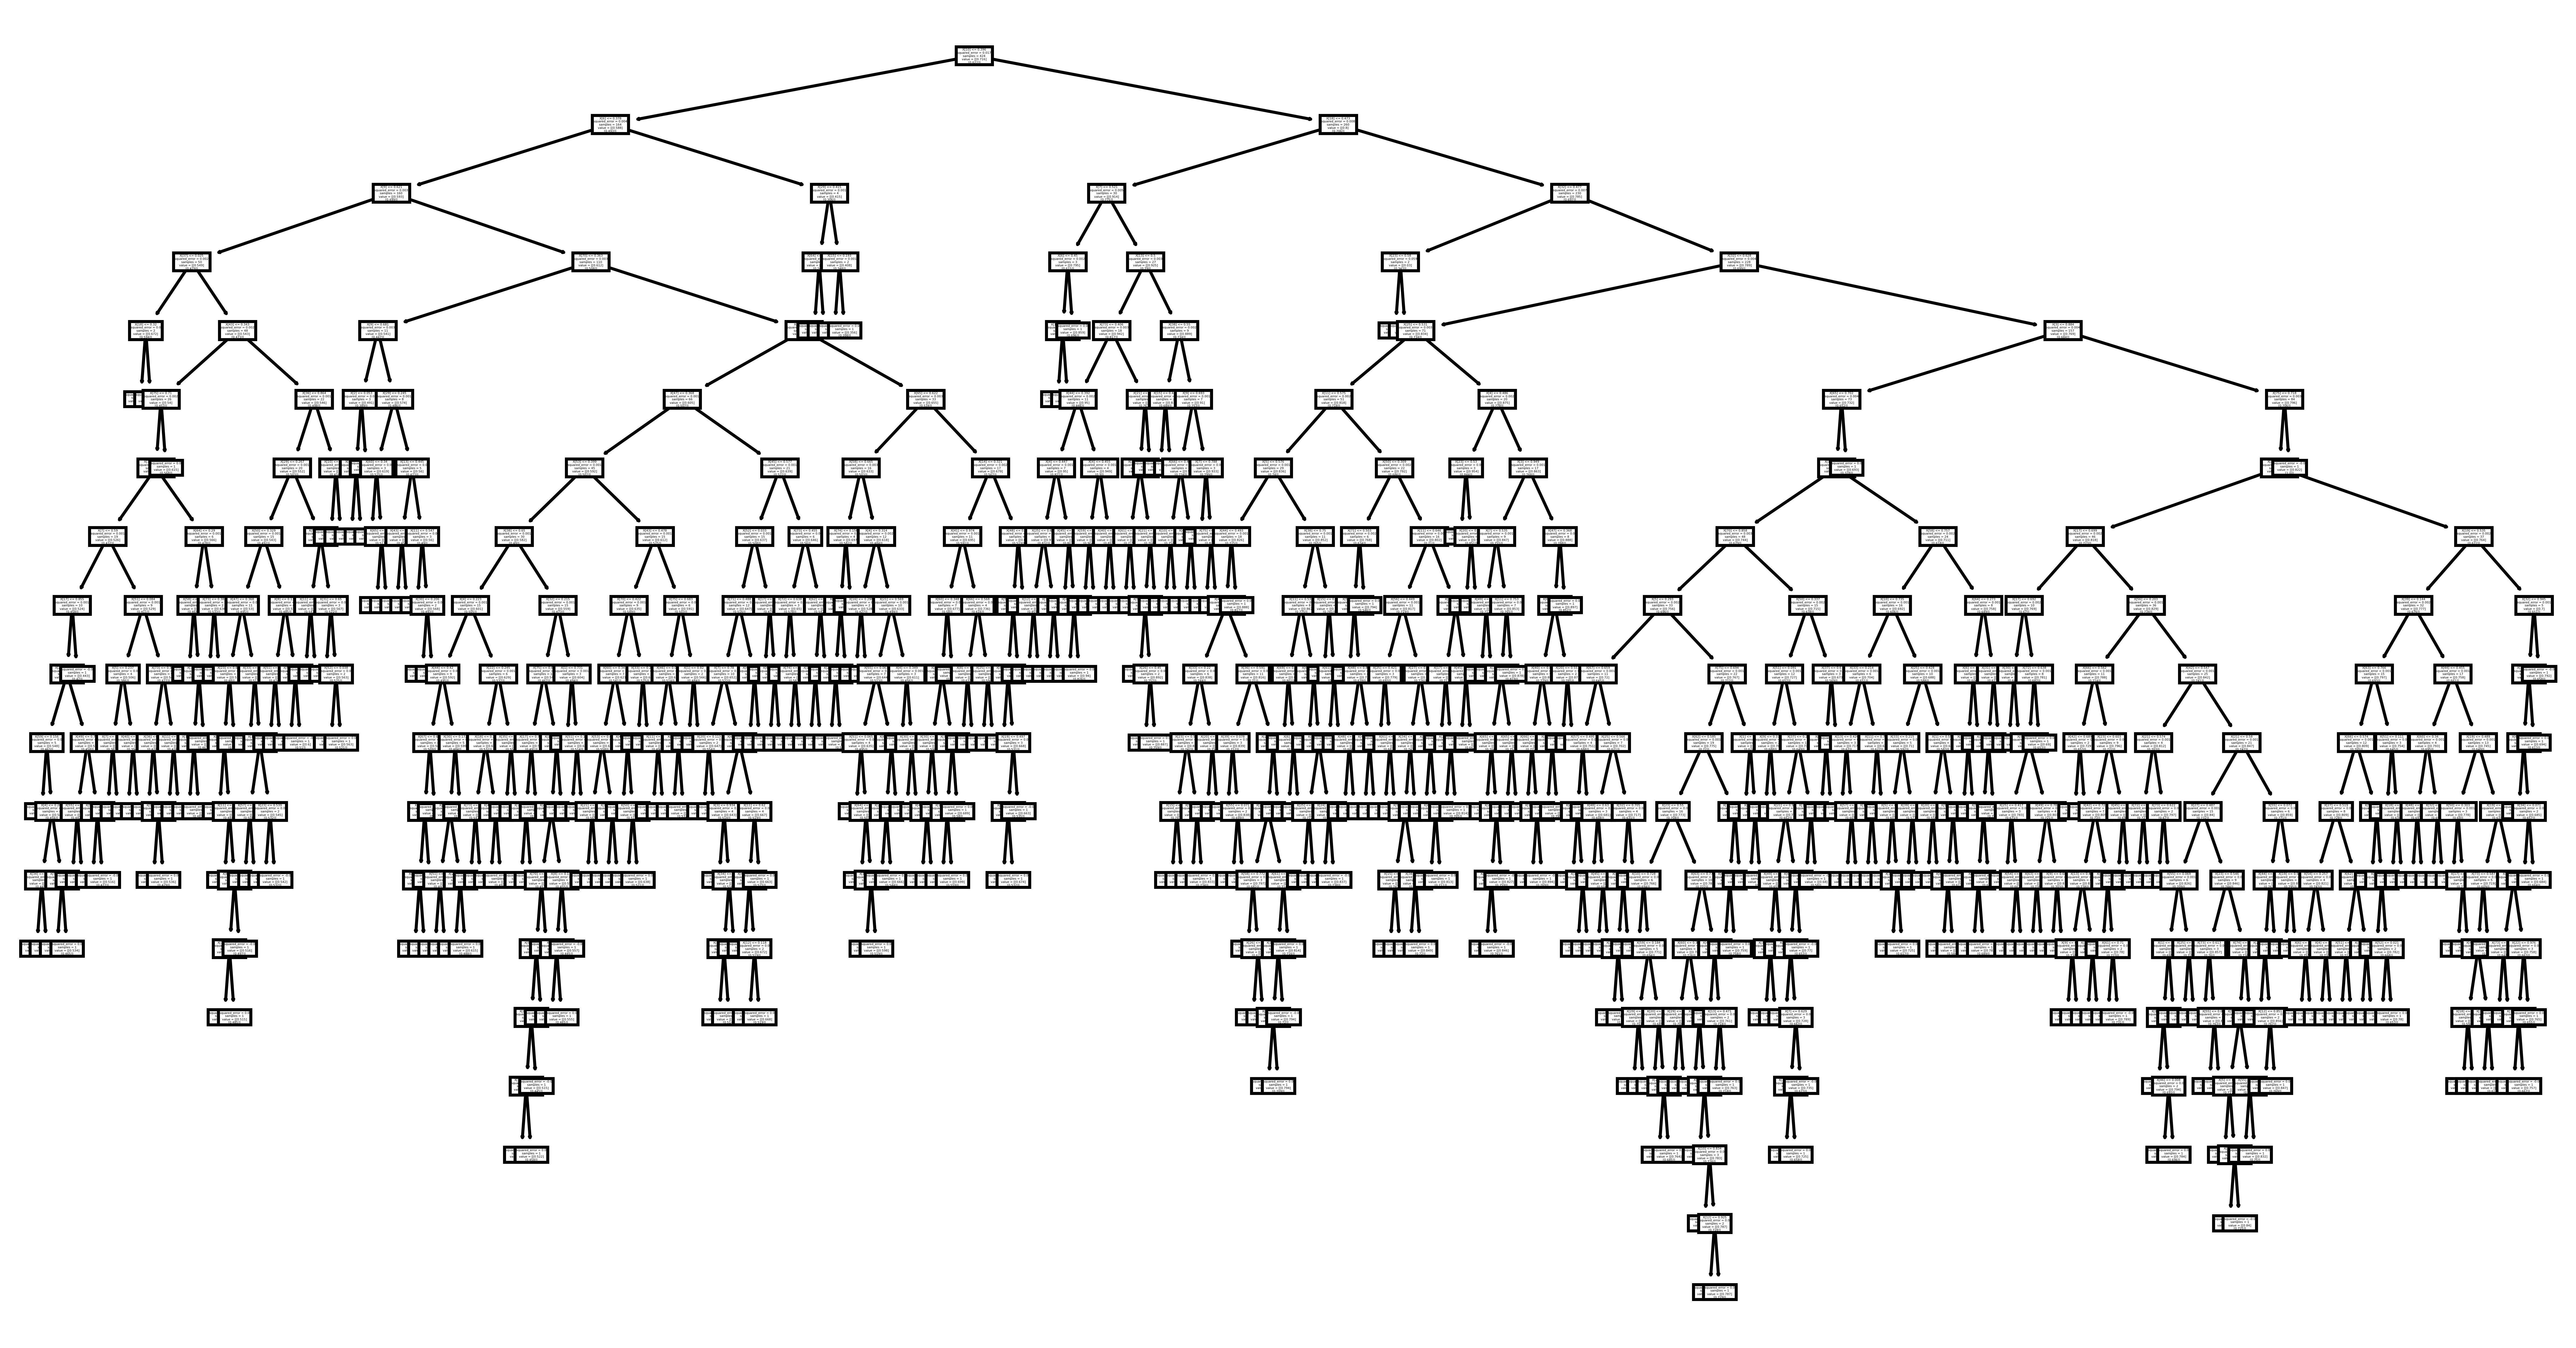

In [74]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,8), dpi=800)
tree.plot_tree(rf.estimators_[0],filled = False);

In [75]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the errors
errors = abs(predictions - test_labels)
pred_sys = [item[0] for item in predictions]
pred_dias = [item[1] for item in predictions]
test_sys = test_labels['sys_val']
test_dias = test_labels['dias_val']
score_sys = r2_score(test_sys,pred_sys)
score_dias = r2_score(test_dias,pred_dias)
print('Systolic Mean Absolute Error:', mean_absolute_error(test_sys, pred_sys))
print('Diastolic Mean Absolute Error:', mean_absolute_error(test_dias, pred_dias))
print('Systolic Mean Squared Error:', mean_squared_error(test_sys, pred_sys))
print('Diastolic Mean Squared Error:', mean_squared_error(test_dias, pred_dias))
print('Systolic Root Mean Squared Error:', mean_squared_error(test_sys, pred_sys, squared=False))
print('Diastolic Root Mean Squared Error:', mean_squared_error(test_dias, pred_dias, squared=False))

Systolic Mean Absolute Error: 0.03949543414332145
Diastolic Mean Absolute Error: 0.041950185137346115
Systolic Mean Squared Error: 0.002432952122826688
Diastolic Mean Squared Error: 0.0028519755873141475
Systolic Root Mean Squared Error: 0.04932496449899065
Diastolic Root Mean Squared Error: 0.05340389112521809


In [76]:
r2['RF'] = [score_sys,score_dias]
mean_absolute['RF'] = [mean_absolute_error(test_sys, pred_sys),mean_absolute_error(test_dias, pred_dias)]
mean_sqrd['RF'] = [mean_squared_error(test_sys, pred_sys),mean_squared_error(test_dias, pred_dias)]
root_mean_sqrd['RF'] = [mean_squared_error(test_sys, pred_sys, squared=False),mean_squared_error(test_dias, pred_dias, squared=False)]

(0.9113787307113687, 6.736569599402187e-66)
(0.8864153193196744, 2.052720749590756e-57)


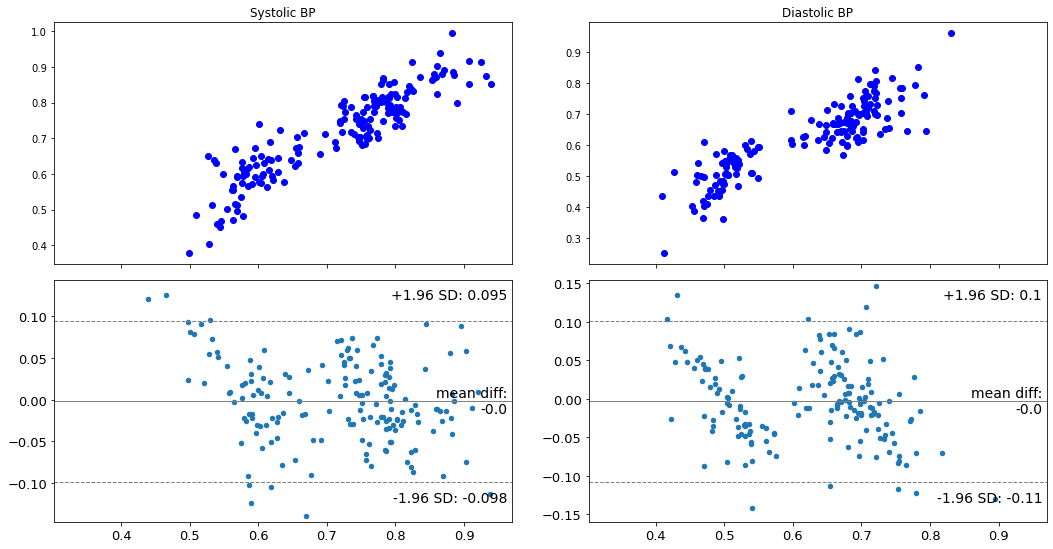

In [77]:
print(scipy.stats.pearsonr(pred_sys, test_sys))
print(scipy.stats.pearsonr(pred_dias, test_dias))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,8),sharex=True)
ax1.plot(pred_sys,test_sys,'bo')
ax1.set_title('Systolic BP')
ax2.plot(pred_dias,test_dias,'bo')
ax2.set_title('Diastolic BP')
sm.graphics.mean_diff_plot(pred_sys, test_sys, ax=ax3)
sm.graphics.mean_diff_plot(pred_dias, test_dias, ax=ax4)
ax3.set_ylabel('')
ax4.set_ylabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
plt.show()

Mean Systolic Pressure (mmHg):  0.7136289532064182
Mean Diastolic Pressure (mmHg):  0.6189488073710497


Text(0.07, 0.5, 'Random Forest')

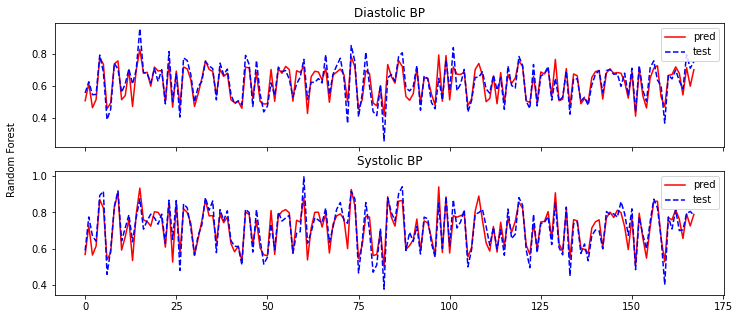

In [78]:
print('Mean Systolic Pressure (mmHg): ', np.mean(pred_sys))
print('Mean Diastolic Pressure (mmHg): ', np.mean(pred_dias))
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(12,5),sharex=True)
ax1.plot(pred_dias,'r-')
ax1.plot(test_dias.reset_index(drop=True),'b--')
ax1.set_title('Diastolic BP')
ax1.legend(['pred','test'])
ax2.plot(pred_sys,'r-')
ax2.plot(test_sys.reset_index(drop=True),'b--')
ax2.legend(['pred','test'])
ax2.set_title('Systolic BP')
fig.text(0.07, 0.5, 'Random Forest', va='center', rotation='vertical')

### Multivariate Regression Model

In [79]:
# systolic model
regr = linear_model.LinearRegression()
regr.fit(train_features,train_labels)
print ("coefficients : ",regr.coef_) 
print ("Intercept : ",regr.intercept_)
predictions = regr.predict(test_features)
# predicting the accuracy score
score = r2_score(test_labels,predictions)
print('r2 score: ',score)
print('mean_abs_error:', mean_absolute_error(test_labels,predictions))
print('mean_sqrd_error: ',mean_squared_error(test_labels,predictions))
print('root_mean_sqrd_error: ',np.sqrt(mean_squared_error(test_labels,predictions)))

coefficients :  [[-5.20879734e+12  1.05712891e-01  7.44107037e+11  1.65565491e-01
   7.44094825e+11 -4.88574982e-01  7.44107537e+11 -6.38898849e-01
   7.44107090e+11  7.69826889e-01  7.44106168e+11  8.28765869e-01
   7.44130968e+11  1.03424072e-01  6.38000488e+00  7.45513916e-01
  -1.25845337e+01 -1.07231140e-01  7.44119217e+11 -1.56491089e+00
   4.20401245e+02  4.32621002e-01 -4.15438354e+02 -4.58221436e-02
   6.30015259e+02  2.62908936e-01  3.31578552e+02 -1.57226562e-01
   9.50538940e+01  3.20434570e-03  4.20468872e+02 -1.33880615e-01
  -4.16385864e+02 -2.43179321e-01 -7.76528524e+08 -1.16245310e+09
   2.02446306e+08 -6.88700227e+08 -9.93805451e+07 -9.32140185e+08
  -1.11434937e-01 -1.18835449e-01  2.61566162e-01  6.20727539e-02
  -1.08276367e-01 -3.18465363e+08 -7.82806396e-01 -6.49211366e+08
  -2.48565674e-02  1.51977539e-02  7.31315613e-01 -5.31250000e-01
   6.75285339e-01 -2.26303101e-01 -7.37052917e-01 -3.31161499e-01
   8.05343628e-01 -4.05006409e-01 -6.62384033e-01  1.9390106

Text(0.07, 0.5, 'Multivariate Regression')

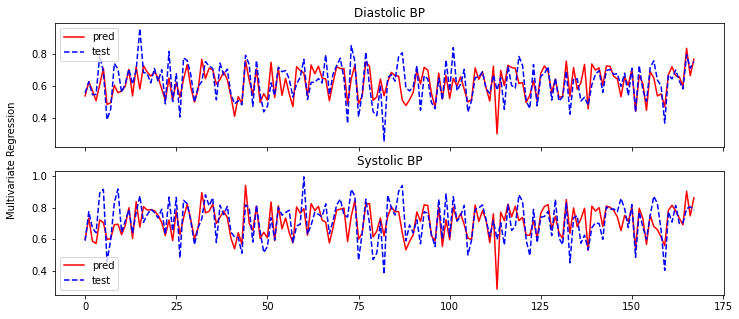

In [80]:
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(12,5),sharex=True)
ax1.plot([item[1] for item in predictions],'r-')
ax1.plot(test_labels['dias_val'].reset_index(drop=True),'b--')
ax1.set_title('Diastolic BP')
ax1.legend(['pred','test'])
ax2.plot([item[0] for item in predictions],'r-')
ax2.plot(test_labels['sys_val'].reset_index(drop=True),'b--')
ax2.legend(['pred','test'])
ax2.set_title('Systolic BP')
fig.text(0.07, 0.5, 'Multivariate Regression', va='center', rotation='vertical')

In [81]:
r2['MVR'] = [score,score]
mean_absolute['MVR'] = [mean_absolute_error(test_labels,predictions),mean_absolute_error(test_labels,predictions)]
mean_sqrd['MVR'] = [mean_squared_error(test_labels,predictions),mean_squared_error(test_labels,predictions)]
root_mean_sqrd['MVR'] = [np.sqrt(mean_squared_error(test_labels,predictions)),np.sqrt(mean_squared_error(test_labels,predictions))]

### Decision Tree Model

r2 score:  0.7942439536370126
Systolic Mean Absolute Error: 0.04388908525347233
mean_sqrd_error:  0.002951901163953288
root_mean_squared error:  0.05433140126992205


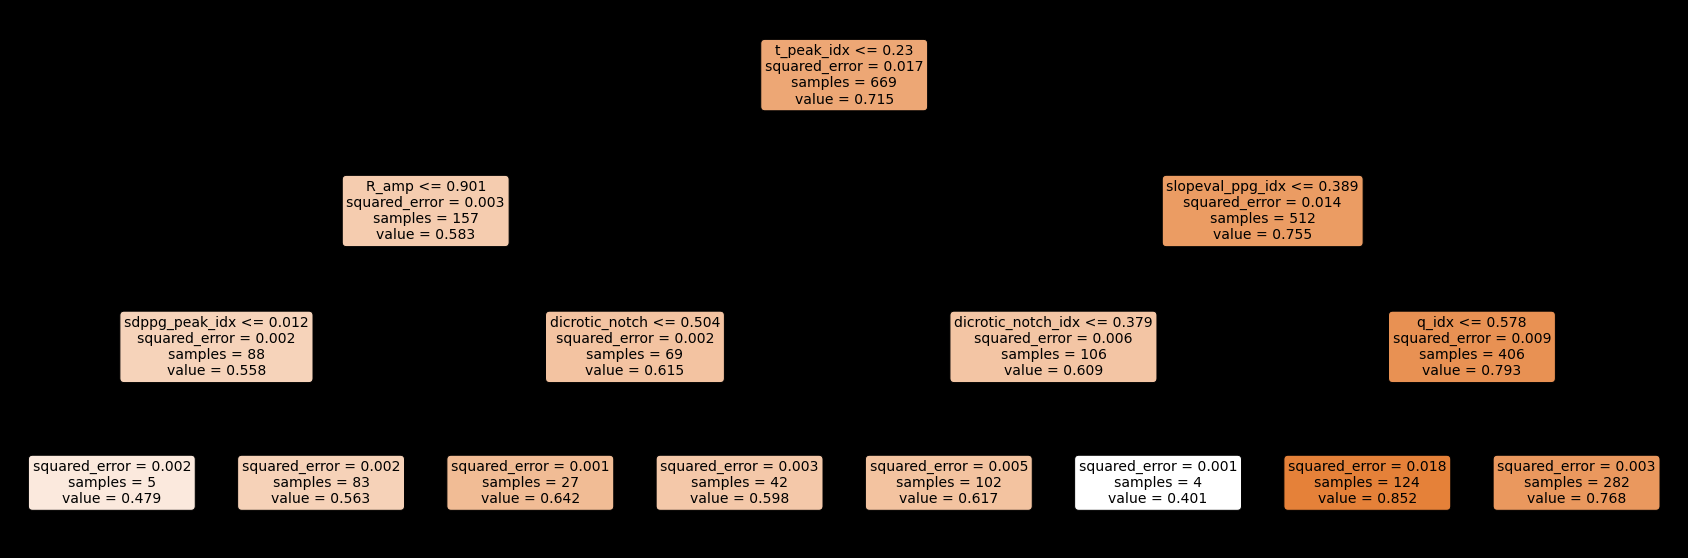

In [82]:
# systolic model
dt = DecisionTreeRegressor(max_depth=3, random_state=42, splitter = 'random')
dt.fit(train_features,train_labels['sys_val'])
sys_predictions = dt.predict(test_features)

score = r2_score(test_labels['sys_val'],sys_predictions)
print('r2 score: ',score)
print('Systolic Mean Absolute Error:', mean_absolute_error(test_labels['sys_val'], sys_predictions))
print('mean_sqrd_error: ',mean_squared_error(test_labels['sys_val'],sys_predictions))
print('root_mean_squared error: ',np.sqrt(mean_squared_error(test_labels['sys_val'],sys_predictions)))

plt.figure(figsize=(30,10),facecolor='k')
a = plot_tree(dt, feature_names = train_features.columns, class_names = 'sys_val', rounded=True, filled=True, fontsize=14)
plt.show()

r2 score:  0.6820803847287717
Diastolic Mean Absolute Error: 0.0492721959015008
mean_sqrd_error:  0.00421884754458846
root_mean_squared error:  0.0649526561780845


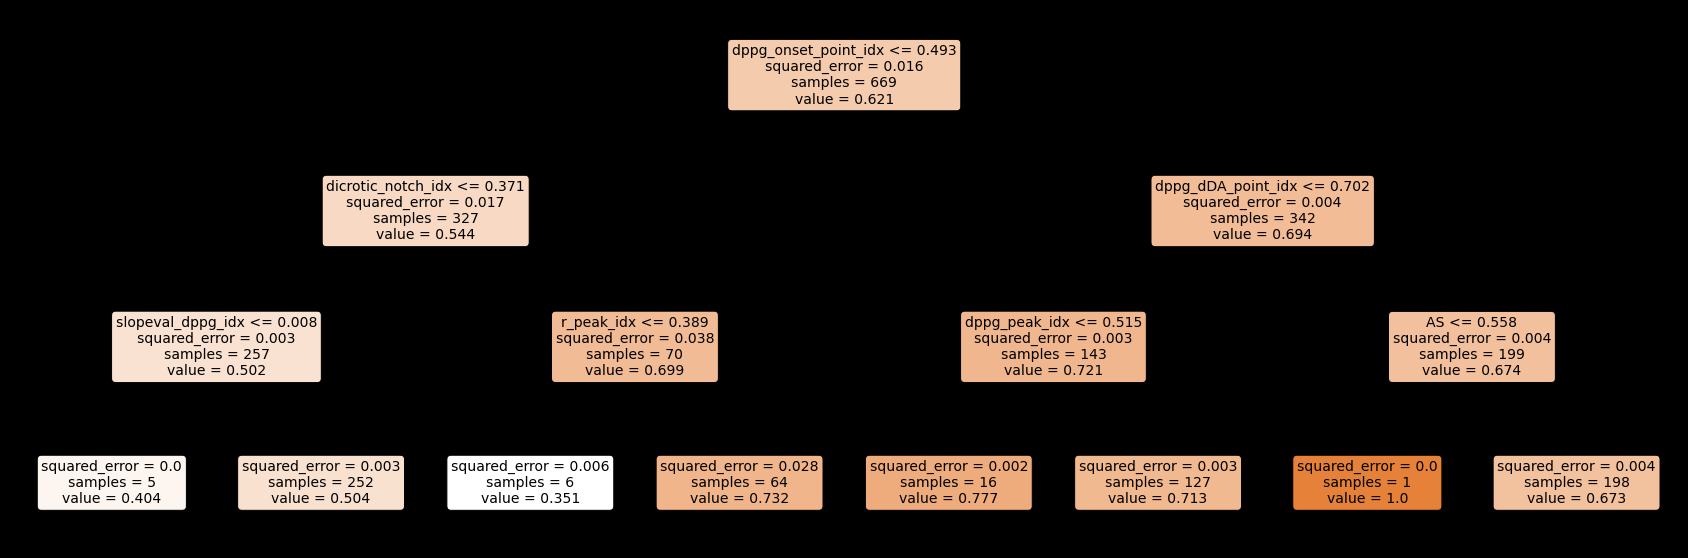

In [83]:
# diastolic model
dt = DecisionTreeRegressor(max_depth=3, random_state=42, splitter = 'random')
dt.fit(train_features,train_labels['dias_val'])
dias_predictions = dt.predict(test_features)

score = r2_score(test_labels['dias_val'],dias_predictions)
print('r2 score: ',score)
print('Diastolic Mean Absolute Error:', mean_absolute_error(test_labels['dias_val'], dias_predictions))
print('mean_sqrd_error: ',mean_squared_error(test_labels['dias_val'],dias_predictions))
print('root_mean_squared error: ',np.sqrt(mean_squared_error(test_labels['dias_val'],dias_predictions)))

plt.figure(figsize=(30,10),facecolor='k')
a = plot_tree(dt, feature_names = train_features.columns, class_names = 'dias_val', rounded=True, filled=True, fontsize=14)
plt.show()

Text(0.07, 0.5, 'Decision Tree')

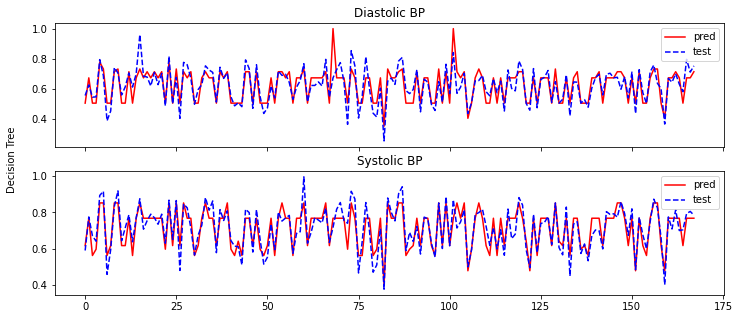

In [84]:
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(12,5),sharex=True)
ax1.plot(dias_predictions,'r-')
ax1.plot(test_labels['dias_val'].reset_index(drop=True),'b--')
ax1.set_title('Diastolic BP')
ax1.legend(['pred','test'])
ax2.plot(sys_predictions,'r-')
ax2.plot(test_labels['sys_val'].reset_index(drop=True),'b--')
ax2.legend(['pred','test'])
ax2.set_title('Systolic BP')
fig.text(0.07, 0.5, 'Decision Tree', va='center', rotation='vertical')

In [85]:
r2['DT'] = [r2_score(test_labels['sys_val'],sys_predictions),r2_score(test_labels['dias_val'],dias_predictions)]
mean_absolute['DT'] = [mean_absolute_error(test_labels['sys_val'], sys_predictions),mean_absolute_error(test_labels['dias_val'], dias_predictions)]
mean_sqrd['DT'] = [mean_squared_error(test_labels['sys_val'],sys_predictions),mean_squared_error(test_labels['dias_val'],dias_predictions)]
root_mean_sqrd['DT'] = [np.sqrt(mean_squared_error(test_labels['sys_val'],sys_predictions)),np.sqrt(mean_squared_error(test_labels['dias_val'],dias_predictions))]

## Performance Metrics

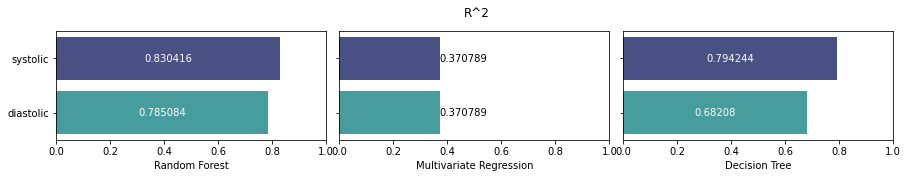

In [86]:
## Comparing R2 Scores
fig,ax = plt.subplots(1,3,figsize=(15,2),sharex=True)
fig.subplots_adjust(wspace=0.05)
g1=sns.barplot(y = ['systolic','diastolic'],x = r2['RF'],ax = ax[0],palette='mako')
g2=sns.barplot(y = ['systolic','diastolic'],x = r2['MVR'],ax = ax[1],palette='mako')
g3=sns.barplot(y = ['systolic','diastolic'],x = r2['DT'],ax=ax[2],palette='mako')
g1.set(xlabel='Random Forest')
g2.set(xlabel='Multivariate Regression')
g3.set(xlabel='Decision Tree')
g2.set(yticklabels=[])
g3.set(yticklabels=[])
g1.bar_label(g1.containers[0],label_type='center',color='white')
g2.bar_label(g2.containers[0],label_type='edge',color='black')
g3.bar_label(g3.containers[0],label_type='center',color='white')
g3.set_xlim(0,1)
plt.suptitle('R^2',fontsize=12,x=0.515,y=1.05)
plt.show()

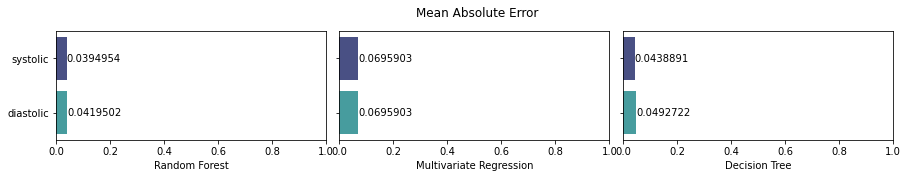

In [87]:
## Comparing Mean Absolute Error Scores
fig,ax = plt.subplots(1,3,figsize=(15,2),sharex=True)
fig.subplots_adjust(wspace=0.05)
g1=sns.barplot(y = ['systolic','diastolic'],x = mean_absolute['RF'],ax = ax[0],palette='mako')
g2=sns.barplot(y = ['systolic','diastolic'],x = mean_absolute['MVR'],ax = ax[1],palette='mako')
g3=sns.barplot(y = ['systolic','diastolic'],x = mean_absolute['DT'],ax=ax[2],palette='mako')
g1.set(xlabel='Random Forest')
g2.set(xlabel='Multivariate Regression')
g3.set(xlabel='Decision Tree')
g2.set(yticklabels=[])
g3.set(yticklabels=[])
g1.bar_label(g1.containers[0],label_type='edge',color='black')
g2.bar_label(g2.containers[0],label_type='edge',color='black')
g3.bar_label(g3.containers[0],label_type='edge',color='black')
g3.set_xlim(0,1)
plt.suptitle('Mean Absolute Error',fontsize=12,x=0.515,y=1.05)
plt.show()

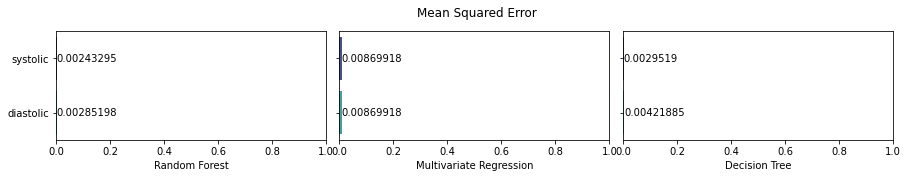

In [88]:
## Comparing Mean Squared Error Scores
fig,ax = plt.subplots(1,3,figsize=(15,2),sharex=True)
fig.subplots_adjust(wspace=0.05)
g1=sns.barplot(y = ['systolic','diastolic'],x = mean_sqrd['RF'],ax = ax[0],palette='mako')
g2=sns.barplot(y = ['systolic','diastolic'],x = mean_sqrd['MVR'],ax = ax[1],palette='mako')
g3=sns.barplot(y = ['systolic','diastolic'],x = mean_sqrd['DT'],ax=ax[2],palette='mako')
g1.set(xlabel='Random Forest')
g2.set(xlabel='Multivariate Regression')
g3.set(xlabel='Decision Tree')
g2.set(yticklabels=[])
g3.set(yticklabels=[])
g1.bar_label(g1.containers[0],label_type='edge',color='black')
g2.bar_label(g2.containers[0],label_type='edge',color='black')
g3.bar_label(g3.containers[0],label_type='edge',color='black')
g3.set_xlim(0,1)
plt.suptitle('Mean Squared Error',fontsize=12,x=0.515,y=1.05)
plt.show()

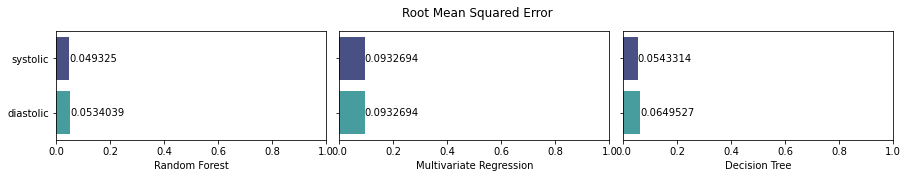

In [89]:
## Comparing Root Mean Squared Error Scores
fig,ax = plt.subplots(1,3,figsize=(15,2),sharex=True)
fig.subplots_adjust(wspace=0.05)
g1=sns.barplot(y = ['systolic','diastolic'],x = root_mean_sqrd['RF'],ax = ax[0],palette='mako')
g2=sns.barplot(y = ['systolic','diastolic'],x = root_mean_sqrd['MVR'],ax = ax[1],palette='mako')
g3=sns.barplot(y = ['systolic','diastolic'],x = root_mean_sqrd['DT'],ax=ax[2],palette='mako')
g1.set(xlabel='Random Forest')
g2.set(xlabel='Multivariate Regression')
g3.set(xlabel='Decision Tree')
g2.set(yticklabels=[])
g3.set(yticklabels=[])
g1.bar_label(g1.containers[0],label_type='edge',color='black')
g2.bar_label(g2.containers[0],label_type='edge',color='black')
g3.bar_label(g3.containers[0],label_type='edge',color='black')
g3.set_xlim(0,1)
plt.suptitle('Root Mean Squared Error',fontsize=12,x=0.515,y=1.05)
plt.show()